# From numbers to images – Raw image processing with Python

Modern digital system cameras and also some digital compact cameras allow to create and to store images in a so-called raw format. A raw image contains

* the minimally pre-processed sensor data,
* meta-data about the picture such as camera model, lens model and camera settings under which the picture has been taken and
* possibly a fully processed preview image.

Raw images are the image format of choice for most serious professional or enthusiast photographers as this format provides the optimal base material for further processing, e.g., tonal adjustments, color grading and all kinds of geometric and lens corrections. Yet, dealing with raw files can be cumbersome. Each camera manufacturer uses its own proprietary raw file format for his cameras. Raw files cannot be displayed directly, the must be processed first. Therefore raw files are sometimes called digital negatives. Raw processing is usually carried out by specialized programs such as [darktable](https://www.darktable.org/) or [RawTherapee](https://rawtherapee.com/).

The Python packages [rawpy](https://letmaik.github.io/rawpy/api/), PIL (aka [Pillow](https://pillow.readthedocs.io/en/stable/)) and [exifread](https://github.com/ianare/exif-py) allow to perform various tasks of raw image processing in Python.  This is particularly useful for batch processing and prototyping of new image processing algorithms. In the following a few demonstrative examples are shown how to use rawpy, PIL and exifread.

Load rawpy and some further useful Python packages first:

In [1]:
import os
from io import BytesIO
import matplotlib.pyplot as plt
import rawpy
import exifread
import numpy as np
from PIL import Image

Read a raw image and extract some basic information about the image:

In [2]:
raw_filename = 'A1_07396.arw'

with rawpy.imread(raw_filename) as raw:
    print(f'raw type:                     {raw.raw_type}')                      # raw type (flat or stack, e.g., Foveon sensor)
    print(f'number of colors:             {raw.num_colors}')                    # number of different color components, e.g., 3 for common RGB Bayer sensors with two green identical green sensors 
    print(f'color description:            {raw.color_desc}')                    # describes the various color components
    print(f'raw pattern:                  {raw.raw_pattern.tolist()}')          # decribes the pattern of the Bayer sensor
    print(f'black levels:                 {raw.black_level_per_channel}')       # black level correction
    print(f'white level:                  {raw.white_level}')                   # camera white level
    print(f'color matrix:                 {raw.color_matrix.tolist()}')         # camera specific color matrix, usually obtained from a list in rawpy (not from the raw file)
    print(f'XYZ to RGB conversion matrix: {raw.rgb_xyz_matrix.tolist()}')       # camera specific XYZ to camara RGB conversion matrix
    print(f'camera white balance:         {raw.camera_whitebalance}')           # the picture's white balance as determined by the camera
    print(f'daylight white balance:       {raw.daylight_whitebalance}')         # the camera's daylight white balance

raw type:                     RawType.Flat
number of colors:             3
color description:            b'RGBG'
raw pattern:                  [[0, 1], [3, 2]]
black levels:                 [512, 512, 512, 512]
white level:                  16383
color matrix:                 [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
XYZ to RGB conversion matrix: [[0.5972999930381775, -0.16949999332427979, -0.04190000146627426], [-0.38260000944137573, 1.1797000169754028, 0.22930000722408295], [-0.06390000134706497, 0.13979999721050262, 0.5788999795913696], [0.0, 0.0, 0.0]]
camera white balance:         [2452.0, 1024.0, 2036.0, 1024.0]
daylight white balance:       [2.836125135421753, 0.9383336305618286, 1.409664511680603, 0.0]


Extract and print EXIF meta-data of the raw file:

In [3]:
with open(raw_filename, 'rb') as f:
    tags = exifread.process_file(f)
    for key, value in tags.items():
        if key is not 'JPEGThumbnail':  # do not print (uninteresting) binary thumbnail data
            print(f'{key}: {value}')

Image SubfileType: Reduced-resolution image
Image Compression: JPEG (old-style)
Image ImageDescription:                                
Image Make: SONY
Image Model: ILCE-6300
Image Orientation: Horizontal (normal)
Image XResolution: 350
Image YResolution: 350
Image ResolutionUnit: Pixels/Inch
Image Software: ILCE-6300 v2.01
Image DateTime: 2019:02:24 12:56:34
Image Artist: Heiko Bauke
Image Tag 0x014A: 145554
Image JPEGInterchangeFormat: 146594
Image JPEGInterchangeFormatLength: 454075
Image YCbCrPositioning: Co-sited
Image Copyright: Heiko Bauke
Image ExifOffset: 484
Image PrintIM: [80, 114, 105, 110, 116, 73, 77, 0, 48, 51, 48, 48, 0, 0, 3, 0, 2, 0, 1, 0, ... ]
Image Tag 0xC634: [156, 201, 0, 0]
Thumbnail SubfileType: Reduced-resolution image
Thumbnail Compression: JPEG (old-style)
Thumbnail ImageDescription:                                
Thumbnail Make: SONY
Thumbnail Model: ILCE-6300
Thumbnail Orientation: Horizontal (normal)
Thumbnail XResolution: 72
Thumbnail YResolution: 72
T

The embedded thumbnail image is extracted from a raw file next. The thumbnail is saved to disk and displayed. (Note that some raw formats have unusual bitmap thumbnails which may not be read correctly or not read at all.)

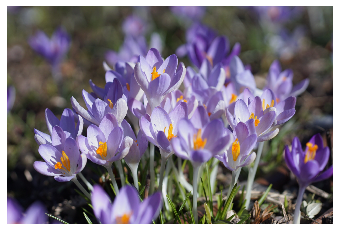

In [4]:
filename, _ = os.path.splitext(raw_filename)
with rawpy.imread(raw_filename) as raw:
    try:
        thumb = raw.extract_thumb()
    except rawpy.LibRawNoThumbnailError:
        print('no thumbnail found')
    else:
        if thumb.format in [rawpy.ThumbFormat.JPEG, rawpy.ThumbFormat.BITMAP]:
            if thumb.format is rawpy.ThumbFormat.JPEG:
                thumb_filename = filename + '_thumb.jpg'
                with open(thumb_filename, 'wb') as f:
                    f.write(thumb.data)
                thumb_rgb = Image.open(BytesIO(thumb.data))
            else:
                thumb_filename = filename + '_thumb.tiff'
                thumb_rgb = Image.fromarray(thumb.data)
                thumb_rgb.save(filename, 'tiff')
            plt.imshow(thumb_rgb)
            plt.axis('off')
        else:
            print('unknown thumbnail format')
        

The next example shows how to process a raw image via rawpy to create an image that is suitable for display. Camera white balance settings are used.

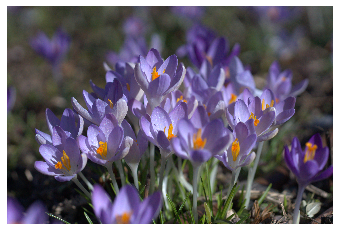

In [5]:
with rawpy.imread(raw_filename) as raw:
    image = raw.raw_image
    rgb = raw.postprocess(rawpy.Params(use_camera_wb=True))
    plt.imshow(rgb)
    plt.axis('off')

A raw image is not suitable for display. The function `postprocess` was utilized before to turn a raw image into an image that can be displayed. In the following, a minimalistic raw conversion into sRGB is performed that yields an image that is suitable for display. The employed procedure is rather general, but it assumes that the camera features a Bayer-pattern sensor. The fundamental element of a Bayer-sensor pattern consists of 2 times 2 pixels of 3 or of 4 different colors. The following steps are required to convert Bayer pixel data into RGB pixels:

* Subtract the black level from raw data.
* Amplify the 3 or 4 color components by the white balance coefficients.
* Demosaic the Bayer pattern. Raw image data contains only one color component at each pixel position. Demosaicing reconstructs a full color image from the incomplete color samples output from the image sensor overlaid with a color filter array, i.e., the Bayer pattern. Here, a simple down sampling approach is implemented for demonstration. This is not a method suitable for high-quality raw conversion.
* Transform the 3 or 4 camera color components into the 3 color components of linear sRGB. Transformations between different color spaces are mediated by matrices. The transformation from linear sRGB into the camera’s primary colors is given by the matrix product of the transformation matrix that transforms color [from sRGB into the XYZ color space](http://www.brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html) and the camera specific matrix that turns XYZ color into camera primaries. The transformation matrix for converting from the camera’s primary colors into sRGB is just the (pseudo-)inverse of this product. Note that the transformation matrix is normalized before inversion in such a way that white in sRGB (all components equal to unity) maps to white in the space of camera’s primaries. See also [Processing RAW Images in MATLAB](https://www.rcsumner.net/raw_guide/) for details.
* In a last step, the sRGB [gamma correction](https://en.wikipedia.org/wiki/SRGB#Specification_of_the_transformation) is applied.

The end result of this procedure is usable but looks rather dull and is lacking contrast. This can be fixed by further processing steps, e.g., the application of an [S-shaped tone curve](https://eng.aurelienpierre.com/2018/11/filmic-darktable-and-the-quest-of-the-hdr-tone-mapping/).

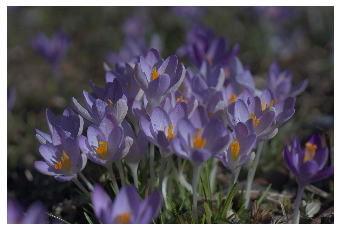

In [6]:
with rawpy.imread(raw_filename) as raw:
    # get raw image data
    image = np.array(raw.raw_image, dtype=np.double)
    # subtract black levels and normalize to interval [0..1]
    black = np.reshape(np.array(raw.black_level_per_channel, dtype=np.double), (2, 2))
    black = np.tile(black, (image.shape[0]//2, image.shape[1]//2))
    image = (image - black) / (raw.white_level - black)
    # find the positions of the three (red, green and blue) or four base colors within the Bayer pattern
    n_colors = raw.num_colors
    colors = np.frombuffer(raw.color_desc, dtype=np.byte)
    pattern = np.array(raw.raw_pattern)
    index_0 = np.where(colors[pattern] == colors[0])
    index_1 = np.where(colors[pattern] == colors[1])
    index_2 = np.where(colors[pattern] == colors[2])
    index_3 = np.where(colors[pattern] == colors[3])
    # apply white balance, normalize white balance coefficients to the 2nd coefficient, which is ususally the coefficient for green
    wb_c = raw.camera_whitebalance 
    wb = np.zeros((2, 2), dtype=np.double) 
    wb[index_0] = wb_c[0] / wb_c[1]
    wb[index_1] = wb_c[1] / wb_c[1]
    wb[index_2] = wb_c[2] / wb_c[1]
    if n_colors == 4:
        wb[index_3] = wb_c[3] / wb_c[1]
    wb = np.tile(wb, (image.shape[0]//2, image.shape[1]//2))
    image_wb = np.clip(image * wb, 0, 1)
    # demosaic via downsampling
    image_demosaiced = np.empty((image_wb.shape[0]//2, image_wb.shape[1]//2, n_colors))
    if n_colors == 3:
        image_demosaiced[:, :, 0] = image_wb[index_0[0][0]::2, index_0[1][0]::2]
        image_demosaiced[:, :, 1] = (image_wb[index_1[0][0]::2, index_1[1][0]::2] + image_wb[index_1[0][1]::2, index_1[1][1]::2]) / 2
        image_demosaiced[:, :, 2] = image_wb[index_2[0][0]::2, index_2[1][0]::2]
    else: # n_colors == 4
        image_demosaiced[:, :, 0] = image_wb[index_0[0][0]::2, index_0[1][0]::2]
        image_demosaiced[:, :, 1] = image_wb[index_1[0][0]::2, index_1[1][0]::2]
        image_demosaiced[:, :, 2] = image_wb[index_2[0][0]::2, index_2[1][0]::2]
        image_demosaiced[:, :, 3] = image_wb[index_3[0][0]::2, index_3[1][0]::2]
    # convert to linear sRGB, calculate the matrix that transforms sRGB into the camera's primary color components and invert this matrix to perform the inverse transformation
    XYZ_to_cam = np.array(raw.rgb_xyz_matrix[0:n_colors, :], dtype=np.double)
    sRGB_to_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
                            [0.2126729, 0.7151522, 0.0721750],
                            [0.0193339, 0.1191920, 0.9503041]], dtype=np.double)
    sRGB_to_cam = np.dot(XYZ_to_cam, sRGB_to_XYZ)
    norm = np.tile(np.sum(sRGB_to_cam, 1), (3, 1)).transpose()
    sRGB_to_cam = sRGB_to_cam / norm
    if n_colors == 3:
        cam_to_sRGB = np.linalg.inv(sRGB_to_cam)
    else: # n_colors == 4
        cam_to_sRGB = np.linalg.pinv(sRGB_to_cam)
    image_sRGB = np.einsum('ij,...j', cam_to_sRGB, image_demosaiced)  # performs the matrix-vector product for each pixel
    # apply sRGB gamma curve
    i = image_sRGB < 0.0031308
    j = np.logical_not(i)
    image_sRGB[i] = 323 / 25 * image_sRGB[i]
    image_sRGB[j] = 211 / 200 * image_sRGB[j] ** (5 / 12) - 11 / 200
    image_sRGB = np.clip(image_sRGB, 0, 1)
    # show image
    plt.axis('off')
    plt.imshow(image_sRGB)
